<a href="https://colab.research.google.com/github/SiMori92/MarketOpen30-DL/blob/main/TQQQ_Step2_Market_Open_30mins_Algo_Training_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Content

##Approach 2 - Keep high correlation

### 1. Inspect Training Set

### 2. Model Training
  - keras.Sequential

### 3. Test on Validation set

##Approach 1 - Keep low correlation

1. Inspect Training Set

2. Model Training

3. Test on Validation set

# Approach 2 - Keep high correlation

## 1. Inspect Training Set

Summary Statistics for Newly Calculated Columns:
       T-1 high-low spread  Pre-market high-low spread  \
count          1471.000000                 1471.000000   
mean              4.886382                    2.410185   
std               3.621169                    2.276124   
min               0.654787                    0.186998   
25%               2.383996                    0.999229   
50%               3.892223                    1.732202   
75%               6.244710                    3.057947   
max              31.386861                   28.670207   

       Market Open compared to Price 1000  \
count                         1471.000000   
mean                             0.049893   
std                              1.436393   
min                             -8.621564   
25%                             -0.693898   
50%                              0.056402   
75%                              0.799285   
max                              9.421570   

       Market Open com

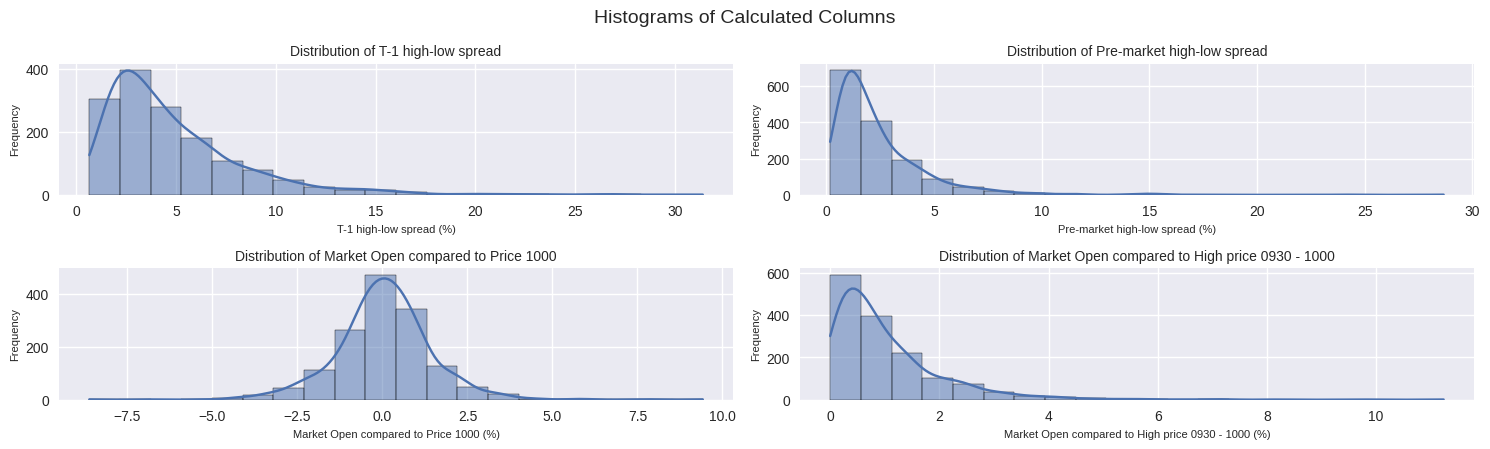

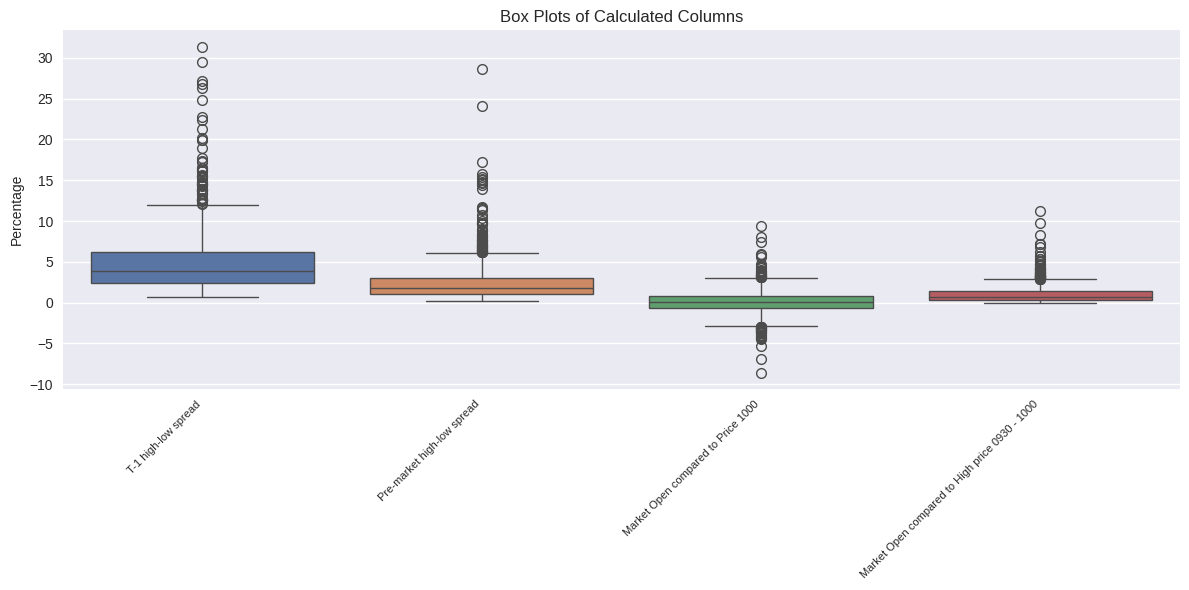

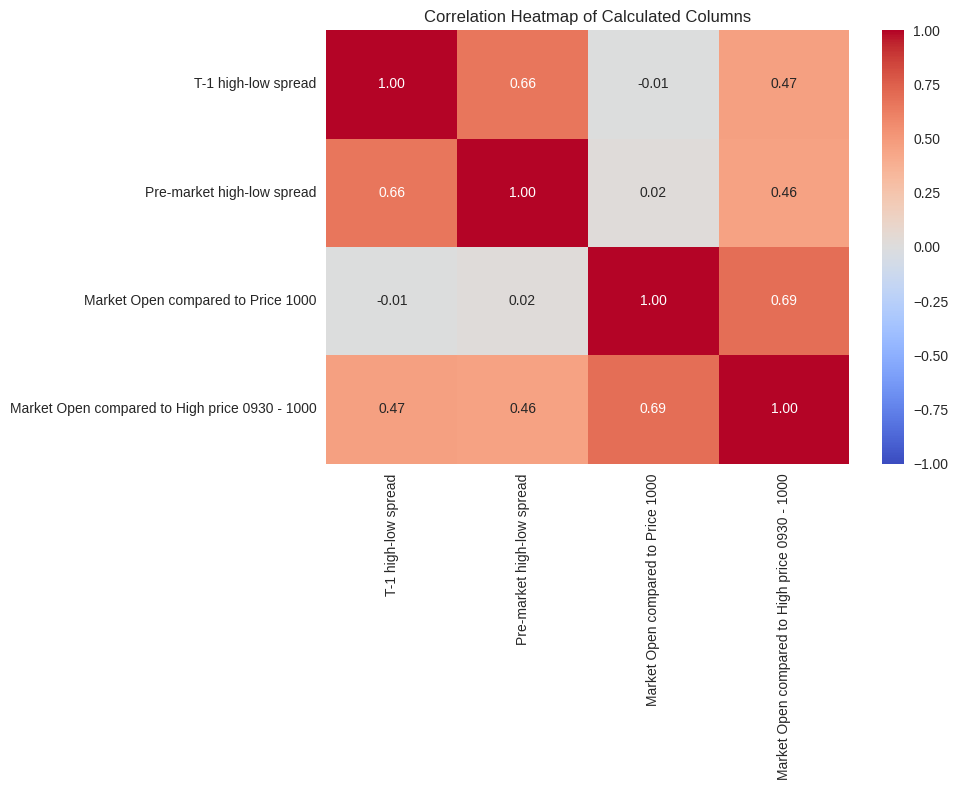

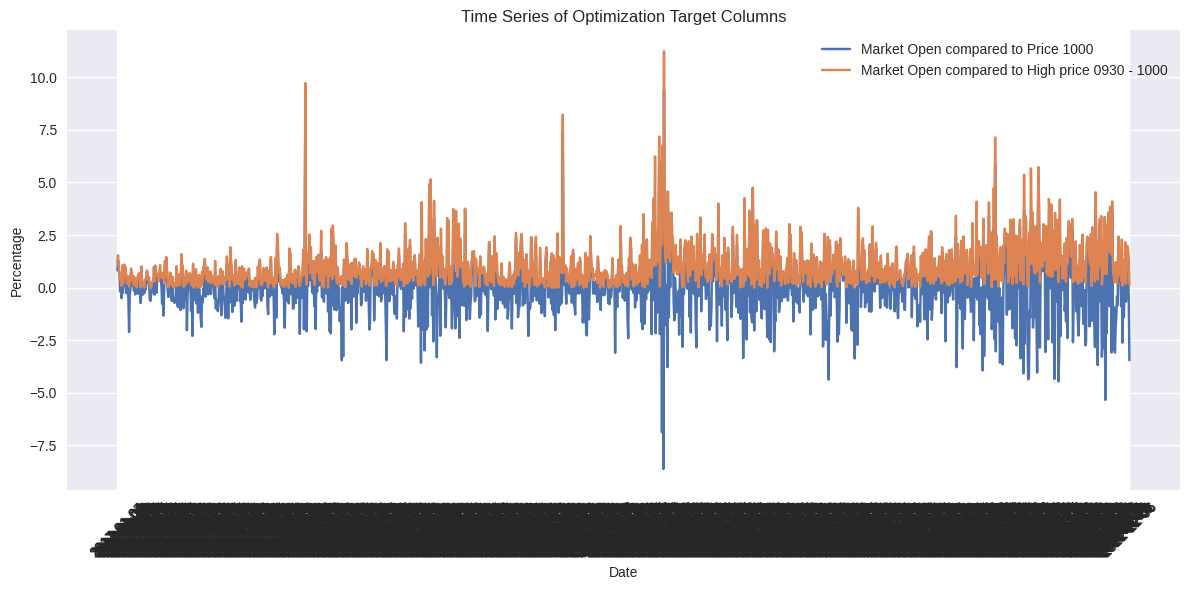

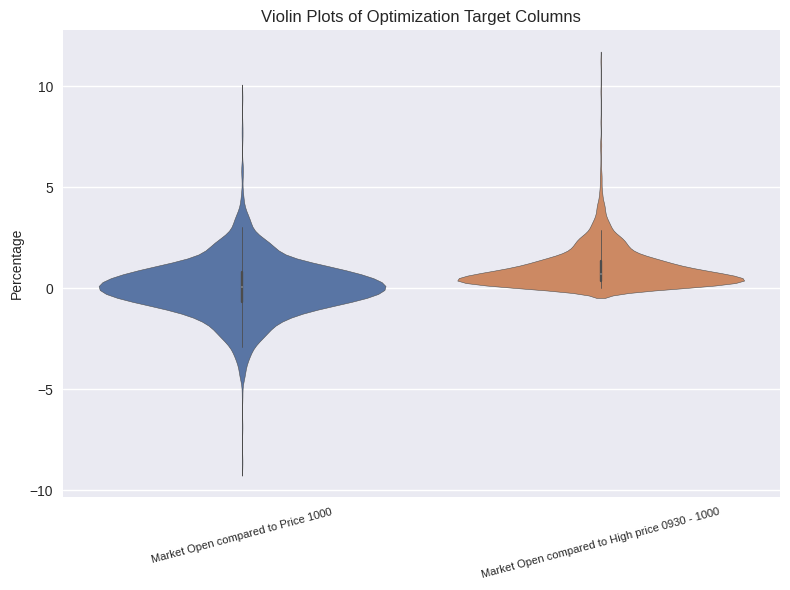


All plots displayed.


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plot style for better visualization
plt.style.use('seaborn-v0_8')  # Use a valid Matplotlib style
sns.set_palette("deep")

# Load the processed CSV data
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    return df

# Inspect and visualize the newly calculated columns
def inspect_metrics(df):
    # Define the new columns to inspect
    new_columns = [
        'T-1 high-low spread',
        'Pre-market high-low spread',
        'Market Open compared to Price 1000',
        'Market Open compared to High price 0930 - 1000'
    ]

    # Summary statistics
    print("Summary Statistics for Newly Calculated Columns:")
    print(df[new_columns].describe())

    # Check for missing values
    print("\nMissing Values in Newly Calculated Columns:")
    print(df[new_columns].isna().sum())

    # Correlation matrix
    print("\nCorrelation Matrix for Newly Calculated Columns:")
    corr_matrix = df[new_columns].corr()
    print(corr_matrix)

    # Detailed analysis for optimization target columns
    target_columns = [
        'Market Open compared to Price 1000',
        'Market Open compared to High price 0930 - 1000'
    ]

    print("\nDetailed Distribution Analysis for Optimization Targets:")
    for col in target_columns:
        print(f"\n--- {col} ---")
        # Skewness and Kurtosis
        print(f"Skewness: {stats.skew(df[col].dropna()):.4f}")
        print(f"Kurtosis: {stats.kurtosis(df[col].dropna()):.4f}")
        # Normality test (Shapiro-Wilk)
        stat, p_value = stats.shapiro(df[col].dropna())
        print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}")
        # Outlier detection using IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))][col]
        print(f"Number of Outliers (IQR method): {len(outliers)}")

    # Visualizations for all calculated columns
    # 1. Histograms for all new columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(new_columns, 1):
        plt.subplot(5, 2, i)
        sns.histplot(df[col].dropna(), kde=True, bins=20)
        plt.title(f'Distribution of {col}', fontsize=10)
        plt.xlabel(f'{col} (%)', fontsize=8)
        plt.ylabel('Frequency', fontsize=8)
        plt.tight_layout()
    plt.suptitle('Histograms of Calculated Columns', fontsize=14, y=1.02)
    plt.show()

    # 2. Box plots for all new columns
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[new_columns])
    plt.title('Box Plots of Calculated Columns', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.ylabel('Percentage', fontsize=10)
    plt.tight_layout()
    plt.show()

    # 3. Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Heatmap of Calculated Columns', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 4. Time series plots for target columns
    plt.figure(figsize=(12, 6))
    for col in target_columns:
        plt.plot(df['Date'], df[col], label=col)
    plt.title('Time Series of Optimization Target Columns', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Percentage', fontsize=10)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 6. Violin plots for target columns
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df[target_columns])
    plt.title('Violin Plots of Optimization Target Columns', fontsize=12)
    plt.xticks(rotation=15, fontsize=8)
    plt.ylabel('Percentage', fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nAll plots displayed.")

# Main execution
if __name__ == "__main__":
    input_file = "train_data_v2.csv"

    # Load and inspect data
    df = load_data(input_file)
    inspect_metrics(df)

## 2. Model Training

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, confusion_matrix

# Load the training data
df_train = pd.read_csv("train_data_v2.csv")

# Ensure 'Date' column is in datetime format
df_train['Date'] = pd.to_datetime(df_train['Date'])

# Extract 'Year' for later use
df_train['Year'] = df_train['Date'].dt.year

# Create time series features for T-1 high-low spread and Pre-market high-low spread
def create_time_series_features(df, columns, lags=[1, 2, 3, 4, 5], window=5):
    df_features = df.copy()
    for col in columns:
        # Add lagged features up to T-5
        for lag in lags:
            df_features[f"{col}_lag_{lag}"] = df[col].shift(lag)
        # Add moving average
        df_features[f"{col}_ma_{window}"] = df[col].rolling(window=window).mean()
    return df_features

# Define columns to create time series features for
ts_columns = ["T-1 high-low spread", "Pre-market high-low spread"]
df_train = create_time_series_features(df_train, ts_columns, lags=[1, 2, 3, 4, 5], window=5)

# Drop rows with NaN values created by lagging and rolling
df_train = df_train.dropna()

# Calculate the defined result for each sample
defined_result = np.where(
    df_train["Market Open compared to High price 0930 - 1000"] >= 1,
    1,
    df_train["Market Open compared to Price 1000"]
)

# Create the target variable: y = 0 (Buy) if defined_result > 0, else y = 1 (Not Buy)
y_train = (defined_result <= 0).astype(int)

# Print class distribution to diagnose imbalance
print(f"Class distribution - Buy (0): {np.mean(y_train == 0):.4f}, Not Buy (1): {np.mean(y_train == 1):.4f}")

# Define input features (including new time series features)
feature_cols = [
    "T-1 high-low spread",
    "T-1 high-low spread_lag_1",
    "T-1 high-low spread_lag_2",
    "T-1 high-low spread_lag_3",
    "T-1 high-low spread_lag_4",
    "T-1 high-low spread_lag_5",
    "T-1 high-low spread_ma_5",
    "Pre-market high-low spread",
    "Pre-market high-low spread_lag_1",
    "Pre-market high-low spread_lag_2",
    "Pre-market high-low spread_lag_3",
    "Pre-market high-low spread_lag_4",
    "Pre-market high-low spread_lag_5",
    "Pre-market high-low spread_ma_5",
]
X_train = df_train[feature_cols].values

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Define focal loss with tuned parameters for higher precision
def focal_loss(gamma=4.0, alpha=0.9):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.ones_like(y_true) * alpha
        alpha_t = tf.where(tf.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        cross_entropy = -tf.math.log(p_t)
        weight = alpha_t * tf.pow((1 - p_t), gamma)
        focal_loss = weight * cross_entropy
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

# Build a model with adjusted architecture
model = tf.keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(len(feature_cols),),
                 kernel_regularizer=regularizers.l2(0.1)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu",
                 kernel_regularizer=regularizers.l2(0.1)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu",
                 kernel_regularizer=regularizers.l2(0.1)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model with focal loss
optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss=focal_loss(gamma=4.0, alpha=0.9),
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_precision', patience=15, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_precision', factor=0.5, patience=5, min_lr=1e-7)
callbacks = [early_stopping, reduce_lr]

# Train the model with class weights
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
          class_weight=class_weight_dict, callbacks=callbacks, verbose=1)

# Find optimal threshold prioritizing precision
y_pred_proba = model.predict(X_train)
precision_scores, recall_scores, thresholds = precision_recall_curve(y_train, y_pred_proba)
f1_scores = 2 * (precision_scores * recall_scores) / (precision_scores + recall_scores + 1e-10)

# Prioritize precision: select threshold where precision is maximized while recall >= 0.2
valid_indices = np.where(recall_scores >= 0.2)[0]
if len(valid_indices) > 0:
    optimal_threshold = thresholds[valid_indices[np.argmax(precision_scores[valid_indices])]]
else:
    optimal_threshold = thresholds[np.argmax(precision_scores)]
optimal_threshold = min(max(optimal_threshold, 0.6), 0.95)
print(f"Optimal threshold: {optimal_threshold:.4f}")

# Export the trained model in HDF5 format
model.save("trading_signal_model_v9.h5")

# Function to calculate defined result based on model predictions
def calculate_defined_result(predictions, df, threshold=optimal_threshold):
    defined_results = []
    for i, pred in enumerate(predictions):
        if pred < threshold:  # Predict Buy (0)
            if df["Market Open compared to High price 0930 - 1000"].iloc[i] >= 1:
                defined_results.append(1)
            else:
                defined_results.append(df["Market Open compared to Price 1000"].iloc[i])
        else:  # Predict Not Buy (1)
            defined_results.append(0)
    return np.array(defined_results)

# Make predictions using optimal threshold
y_pred = (y_pred_proba > optimal_threshold).astype(int).flatten()
defined_results = calculate_defined_result(y_pred_proba, df_train, optimal_threshold)


# Calculate daily_return based on the specified conditions
daily_return_base = np.where(
    df_train["Market Open compared to High price 0930 - 1000"] >= 1,
    1,
    df_train["Market Open compared to Price 1000"]
)

# Create results_df with necessary columns for yearly calculations
results_df = pd.DataFrame({
    'Year': df_train['Year'],
    'y_true': y_train,
    'y_pred': y_pred,
    'defined_results': defined_results,
    'daily_return': daily_return_base  # For baseline calculation
})

# Calculate yearly confusion matrix, model accumulated return, and baseline accumulated return
yearly_groups = results_df.groupby('Year')
yearly_stats = {}
for year, group in yearly_groups:
    cm = confusion_matrix(group['y_true'], group['y_pred'], labels=[0, 1])
    tp = cm[0, 0]  # True Positives: Predicted Buy, Actual Buy
    fn = cm[0, 1]  # False Negatives: Predicted Not Buy, Actual Buy
    fp = cm[1, 0]  # False Positives: Predicted Buy, Actual Not Buy
    tn = cm[1, 1]  # True Negatives: Predicted Not Buy, Actual Not Buy
    model_accumulated_return = group['defined_results'].sum()
    baseline_accumulated_return = group['daily_return'].sum()  # Sum of daily returns for the year
    yearly_stats[year] = {
        'TP': tp,
        'FN': fn,
        'FP': fp,
        'TN': tn,
        'Accumulated Return (Model)': model_accumulated_return,
        'Baseline Accumulated Return': baseline_accumulated_return
    }

# Print yearly statistics with baseline comparison
print("\nYearly Trading Performance:")
for year, stats in yearly_stats.items():
    print(f"Year {year}:")
    print("  Confusion Matrix:")
    print(f"    True Positives (TP): {stats['TP']}")
    print(f"    False Negatives (FN): {stats['FN']}")
    print(f"    False Positives (FP): {stats['FP']}")
    print(f"    True Negatives (TN): {stats['TN']}")
    print(f"  Accumulated Return (Model): {stats['Accumulated Return (Model)']:.4f}")
    print(f"  Baseline Accumulated Return (Buying Every Day): {stats['Baseline Accumulated Return']:.4f}")

# Calculate overall accumulated return if buying every day (Baseline)
accumulated_return_every_day = df_train["Market Open compared to Price 1000"].sum()

# Print the overall baseline result
print(f"\n=== Overall Baseline Comparison ===")
print(f"Accumulated Return if Buying Every Day (Overall Baseline): {accumulated_return_every_day:.4f}")

# Evaluate overall model performance
false_negatives = ((y_pred == 1) & (defined_result > 0)).sum()
false_positives = ((y_pred == 0) & (defined_results <= 0)).sum()
buy_predictions = (y_pred == 0).sum()
total_positives = (defined_result > 0).sum()

print(f"\n=== Model Performance with Optimized Threshold ===")
print(f"Number of missed positive results (False Negatives): {false_negatives}")
print(f"Number of Buy predictions leading to loss: {false_positives}")
print(f"Total Buy predictions: {buy_predictions}")
print(f"Total positive opportunities: {total_positives}")
print(f"Proportion of missed positives: {false_negatives / total_positives:.4f}")
if buy_predictions > 0:
    print(f"Proportion of Buy predictions leading to loss: {false_positives / buy_predictions:.4f}")
    print(f"Precision (successful buys): {(buy_predictions - false_positives) / buy_predictions:.4f}")
print(f"Recall (caught opportunities): {(total_positives - false_negatives) / total_positives:.4f}")

# Trading summary
successful_buys = buy_predictions - false_positives
captured_profit = total_positives - false_negatives

print(f"\n=== Trading Performance Summary ===")
print(f"Successful buy signals: {successful_buys}")
print(f"Captured profit opportunities: {captured_profit} out of {total_positives}")
print(f"Profit capture rate: {captured_profit / total_positives:.4f}")

Class distribution - Buy (0): 0.5819, Not Buy (1): 0.4181
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 15.3561 - precision_8: 0.3898 - recall_8: 0.4684 - val_loss: 14.9811 - val_precision_8: 0.3782 - val_recall_8: 0.5673 - learning_rate: 5.0000e-05
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_precision` which is not available. Available metrics are: loss,precision_8,recall_8,val_loss,val_precision_8,val_recall_8
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_precision` which is not available. Available metrics are: loss,precision_8,recall_8,val_loss,val_precision_8,val_recall_8,learning_rate.
  callback.on_epoch_end(epoch, logs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.0139 - precision_8: 0.4491 - recall_8: 0.5633 - val_loss: 14.6401 - val_precision_8: 0.3700 - val_recall_8: 0.8077 - learning_rate: 5.0000e-05
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.6768 - precision_8: 0.4305 - recall_8: 0.5063 - val_loss: 14.3118 - val_precision_8: 0.3586 - val_recall_8: 0.8654 - learning_rate: 5.0000e-05
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.3549 - precision_8: 0.4649 - recall_8: 0.5555 - val_loss: 13.9938 - val_precision_8: 0.3654 - val_recall_8: 0.9135 - learning_rate: 5.0000e-05
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.0159 - precision_8: 0.4327 - recall_8: 0.5182 - val_loss: 13.6821 - val_precision_8: 0.3626 - val_recall_8: 0.9135 - learning_rate: 5.0000e-05
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.6953 - precision_8: 0.4713 - recall_8: 0.5732 - val_loss: 13.3767 - val_precision_8: 0.3612 - val_recall_8: 0.9135 - learning_rate

Optimal threshold: 0.6903

Yearly Trading Performance:
Year 2017:
  Confusion Matrix:
    True Positives (TP): 112
    False Negatives (FN): 8
    False Positives (FP): 111
    True Negatives (TN): 14
  Accumulated Return (Model): -8.6581
  Baseline Accumulated Return (Buying Every Day): -13.8581
Year 2018:
  Confusion Matrix:
    True Positives (TP): 126
    False Negatives (FN): 20
    False Positives (FP): 78
    True Negatives (TN): 22
  Accumulated Return (Model): 21.3569
  Baseline Accumulated Return (Buying Every Day): 8.4638
Year 2019:
  Confusion Matrix:
    True Positives (TP): 116
    False Negatives (FN): 15
    False Positives (FP): 95
    True Negatives (TN): 22
  Accumulated Return (Model): 12.1392
  Baseline Accumulated Return (Buying Every Day): 7.1698
Year 2020:
  Confusion Matrix:
    True Positives (TP): 130
    False Negatives (FN): 28
    False Positives (FP): 58
    True Negatives (TN): 31
  Accumulated Return (Model): 47.2533
  Baseline Accumulated Return (Buyin

Class weights: {0: np.float64(0.8582263710618436), 1: np.float64(1.1978827361563518)}
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5534 - f1_metric: 0.2546 - loss: 0.9150 - val_accuracy: 0.6939 - val_f1_metric: 0.7210 - val_loss: 0.7307 - learning_rate: 0.0010
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5260 - f1_metric: 0.3079 - loss: 0.8838 - val_accuracy: 0.7813 - val_f1_metric: 0.8047 - val_loss: 0.7078 - learning_rate: 0.0010
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5432 - f1_metric: 0.3554 - loss: 0.7920 - val_accuracy: 0.7813 - val_f1_metric: 0.8135 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5593 - f1_metric: 0.4146 - loss: 0.7604 - val_accuracy: 0.7697 - val_f1_metric: 0.8122 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5020 - f1_metric: 0.4122 - loss: 0.7926 - val_accuracy: 0.7609 - val_f1_metric: 0.8074 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


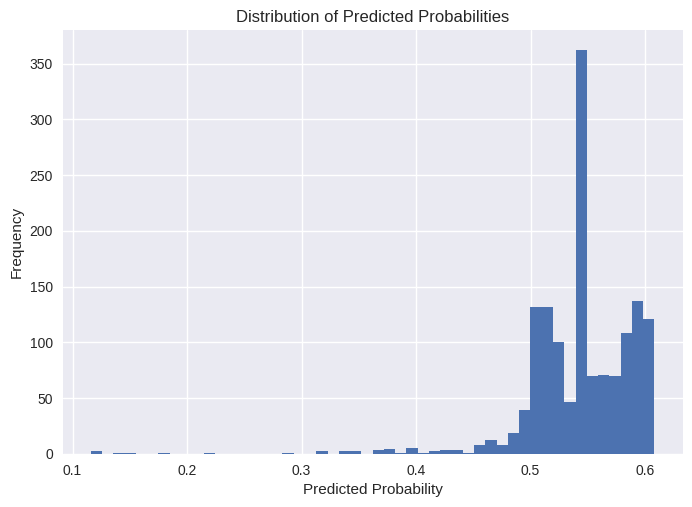

Optimal threshold: 0.610

Confusion Matrix:
[[857   0]
 [614   0]]

=== Model Performance with Optimized Threshold ===
Number of missed positive results (False Negatives): 0
Number of Buy predictions leading to loss: 614
Total Buy predictions: 1471
Total positive opportunities: 857
Proportion of missed positives: 0.0000
Proportion of Buy predictions leading to loss: 0.4174
Precision (successful buys): 0.5826
Recall (caught opportunities): 1.0000

=== Trading Performance Summary ===
Successful buy signals: 857
Captured profit opportunities: 857 out of 857
Profit capture rate: 1.0000


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the training data
df_train = pd.read_csv("train_data_v2.csv")

# Calculate the defined result for each sample
defined_result = np.where(
    df_train["Market Open compared to High price 0930 - 1000"] >= 1,
    1,
    df_train["Market Open compared to Price 1000"]
)

# Create the target variable: y = 0 (Buy) if defined_result > 0, else y = 1 (Not Buy)
y_train = (defined_result <= 0).astype(int)

# Define input features
feature_cols = [
    "T-1 high-low spread",
    "Pre-market high-low spread"
]
X_train = df_train[feature_cols].values

# Scale features using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# Custom F1 score metric
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)

    tp = K.sum(K.cast(y_true * y_pred, 'float32'))
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

# Enhanced model architecture
model = tf.keras.Sequential([
    layers.Dense(32, input_shape=(2,), kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(16, kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(8, kernel_regularizer=regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),
    layers.Dropout(0.2),

    layers.Dense(1, activation="sigmoid")
])

# Compile with binary cross-entropy
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", f1_metric]
)

# Callbacks with F1 monitoring
early_stopping = EarlyStopping(
    monitor='val_f1_metric',
    patience=50,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_metric',
    factor=0.5,
    patience=20,
    mode='max',
    min_lr=0.00001
)

# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Export the trained model
model.save("trading_signal_model_v7.h5")

# Function to calculate defined result
def calculate_defined_result(predictions, df):
    defined_results = []
    for i, pred in enumerate(predictions):
        if pred < 0.5:  # Predict Buy (0)
            if df["Market Open compared to High price 0930 - 1000"].iloc[i] >= 1:
                defined_results.append(1)
            else:
                defined_results.append(df["Market Open compared to Price 1000"].iloc[i])
        else:  # Predict Not Buy (1)
            defined_results.append(0)
    return np.array(defined_results)

# Make predictions and optimize threshold
y_pred_proba = model.predict(X_train)

# Analyze probability distribution
plt.hist(y_pred_proba, bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

# Find optimal threshold for weighted F1 score (prioritizing precision)
thresholds = np.arange(0.05, 0.95, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred_temp = (y_pred_proba > threshold).astype(int).flatten()
    defined_results_temp = calculate_defined_result(y_pred_temp, df_train)

    tp = ((y_pred_temp == 0) & (defined_result > 0)).sum()
    fp = ((y_pred_temp == 0) & (defined_results_temp <= 0)).sum()
    fn = ((y_pred_temp == 1) & (defined_result > 0)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Weighted F1 to prioritize precision (reduce false positives)
    weighted_f1 = (1.5 * precision * recall) / (0.5 * precision + recall) if (precision + recall) > 0 else 0

    if weighted_f1 > best_f1:
        best_f1 = weighted_f1
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}")

# Final predictions with optimal threshold
y_pred = (y_pred_proba > best_threshold).astype(int).flatten()
defined_results = calculate_defined_result(y_pred, df_train)

# Evaluate performance
false_negatives = ((y_pred == 1) & (defined_result > 0)).sum()
false_positives = ((y_pred == 0) & (defined_results <= 0)).sum()
buy_predictions = (y_pred == 0).sum()
total_positives = (defined_result > 0).sum()

# Confusion matrix
cm = confusion_matrix(y_train, y_pred)
print(f"\nConfusion Matrix:\n{cm}")

print(f"\n=== Model Performance with Optimized Threshold ===")
print(f"Number of missed positive results (False Negatives): {false_negatives}")
print(f"Number of Buy predictions leading to loss: {false_positives}")
print(f"Total Buy predictions: {buy_predictions}")
print(f"Total positive opportunities: {total_positives}")
print(f"Proportion of missed positives: {false_negatives / total_positives:.4f}")
if buy_predictions > 0:
    print(f"Proportion of Buy predictions leading to loss: {false_positives / buy_predictions:.4f}")
    print(f"Precision (successful buys): {(buy_predictions - false_positives) / buy_predictions:.4f}")
print(f"Recall (caught opportunities): {(total_positives - false_negatives) / total_positives:.4f}")

# Trading summary
successful_buys = buy_predictions - false_positives
captured_profit = total_positives - false_negatives

print(f"\n=== Trading Performance Summary ===")
print(f"Successful buy signals: {successful_buys}")
print(f"Captured profit opportunities: {captured_profit} out of {total_positives}")
print(f"Profit capture rate: {captured_profit / total_positives:.4f}")

## 3. Test on Validation set

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Define the focal loss function used during training
def focal_loss(gamma=4.0, alpha=0.9):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.ones_like(y_true) * alpha
        alpha_t = tf.where(tf.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        cross_entropy = -tf.math.log(p_t)
        weight = alpha_t * tf.pow((1 - p_t), gamma)
        focal_loss = weight * cross_entropy
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

# Load the saved model with custom loss function
model = tf.keras.models.load_model("trading_signal_model_v9.h5", custom_objects={'focal_loss_fixed': focal_loss(gamma=4.0, alpha=0.9)})

# Load validation data from CSV
df_val = pd.read_csv("val_data_v2.csv")

# Preprocess validation data
df_val['Date'] = pd.to_datetime(df_val['Date'])
df_val['Year'] = df_val['Date'].dt.year

# Define columns for time series features
ts_columns = ["T-1 high-low spread", "Pre-market high-low spread"]

# Function to create time series features (lagged values and moving averages)
def create_time_series_features(df, columns, lags=[1, 2, 3, 4, 5], window=5):
    df_features = df.copy()
    for col in columns:
        for lag in lags:
            df_features[f"{col}_lag_{lag}"] = df[col].shift(lag)
        df_features[f"{col}_ma_{window}"] = df[col].rolling(window=window).mean()
    return df_features

# Apply feature creation and drop NaN values
df_val = create_time_series_features(df_val, ts_columns)
df_val = df_val.dropna()

# Define feature columns consistent with training
feature_cols = [
    "T-1 high-low spread",
    "T-1 high-low spread_lag_1",
    "T-1 high-low spread_lag_2",
    "T-1 high-low spread_lag_3",
    "T-1 high-low spread_lag_4",
    "T-1 high-low spread_lag_5",
    "T-1 high-low spread_ma_5",
    "Pre-market high-low spread",
    "Pre-market high-low spread_lag_1",
    "Pre-market high-low spread_lag_2",
    "Pre-market high-low spread_lag_3",
    "Pre-market high-low spread_lag_4",
    "Pre-market high-low spread_lag_5",
    "Pre-market high-low spread_ma_5",
]

# Prepare input features
X_val = df_val[feature_cols].values

# Scale features (Note: Ideally, use the scaler fitted on training data; here we fit a new one)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)

# Calculate ground truth defined_result for validation
defined_result_val = np.where(
    df_val["Market Open compared to High price 0930 - 1000"] >= 1,
    1,
    df_val["Market Open compared to Price 1000"]
)
y_val = (defined_result_val <= 0).astype(int)

# Make predictions with the model
y_pred_proba_val = model.predict(X_val)

# Set the optimal threshold (replace with the value determined from training)
optimal_threshold = 0.7  # Example value; adjust based on training output
y_pred_val = (y_pred_proba_val > optimal_threshold).astype(int).flatten()

# Function to calculate trading results based on predictions
def calculate_defined_result(predictions, df, threshold):
    defined_results = []
    for i, pred in enumerate(predictions):
        if pred < threshold:  # Predict Buy (0)
            if df["Market Open compared to High price 0930 - 1000"].iloc[i] >= 1:
                defined_results.append(1)
            else:
                defined_results.append(df["Market Open compared to Price 1000"].iloc[i])
        else:  # Predict Not Buy (1)
            defined_results.append(0)
    return np.array(defined_results)

# Calculate defined results for validation
defined_results_val = calculate_defined_result(y_pred_proba_val, df_val, optimal_threshold)

# Create results DataFrame
results_df_val = pd.DataFrame({
    'Year': df_val['Year'],
    'y_true': y_val,
    'y_pred': y_pred_val,
    'defined_results': defined_results_val,
    'daily_return': df_val["Market Open compared to Price 1000"]
})

# Compute yearly statistics
yearly_groups_val = results_df_val.groupby('Year')
yearly_stats_val = {}
for year, group in yearly_groups_val:
    cm = confusion_matrix(group['y_true'], group['y_pred'], labels=[0, 1])
    tp = cm[0, 0]
    fn = cm[0, 1]
    fp = cm[1, 0]
    tn = cm[1, 1]
    model_accumulated_return = group['defined_results'].sum()
    baseline_accumulated_return = group['daily_return'].sum()
    yearly_stats_val[year] = {
        'TP': tp,
        'FN': fn,
        'FP': fp,
        'TN': tn,
        'Accumulated Return (Model)': model_accumulated_return,
        'Baseline Accumulated Return': baseline_accumulated_return
    }

# Print yearly performance
print("\nYearly Validation Performance:")
for year, stats in yearly_stats_val.items():
    print(f"Year {year}:")
    print("  Confusion Matrix:")
    print(f"    True Positives (TP): {stats['TP']}")
    print(f"    False Negatives (FN): {stats['FN']}")
    print(f"    False Positives (FP): {stats['FP']}")
    print(f"    True Negatives (TN): {stats['TN']}")
    print(f"  Accumulated Return (Model): {stats['Accumulated Return (Model)']:.4f}")
    print(f"  Baseline Accumulated Return: {stats['Baseline Accumulated Return']:.4f}")

# Compute overall metrics
overall_cm = confusion_matrix(y_val, y_pred_val, labels=[0, 1])
print("\nOverall Confusion Matrix:")
print(overall_cm)

overall_model_accumulated_return = results_df_val['defined_results'].sum()
overall_baseline_accumulated_return = results_df_val['daily_return'].sum()
print(f"Overall Accumulated Return (Model): {overall_model_accumulated_return:.4f}")
print(f"Overall Baseline Accumulated Return: {overall_baseline_accumulated_return:.4f}")

# Additional performance metrics
false_negatives_val = ((y_pred_val == 1) & (defined_result_val > 0)).sum()
false_positives_val = ((y_pred_val == 0) & (defined_results_val <= 0)).sum()
buy_predictions_val = (y_pred_val == 0).sum()
total_positives_val = (defined_result_val > 0).sum()

print(f"\n=== Validation Performance ===")
print(f"Number of missed positive results (False Negatives): {false_negatives_val}")
print(f"Number of Buy predictions leading to loss: {false_positives_val}")
print(f"Total Buy predictions: {buy_predictions_val}")
print(f"Total positive opportunities: {total_positives_val}")
if total_positives_val > 0:
    print(f"Proportion of missed positives: {false_negatives_val / total_positives_val:.4f}")
if buy_predictions_val > 0:
    print(f"Proportion of Buy predictions leading to loss: {false_positives_val / buy_predictions_val:.4f}")
    print(f"Precision (successful buys): {(buy_predictions_val - false_positives_val) / buy_predictions_val:.4f}")
if total_positives_val > 0:
    print(f"Recall (caught opportunities): {(total_positives_val - false_negatives_val) / total_positives_val:.4f}")

# Trading performance summary
successful_buys = buy_predictions_val - false_positives_val
captured_profit = total_positives_val - false_negatives_val

print(f"\n=== Trading Performance Summary ===")
print(f"Successful buy signals: {successful_buys}")
print(f"Captured profit opportunities: {captured_profit} out of {total_positives_val}")
if total_positives_val > 0:
    print(f"Profit capture rate: {captured_profit / total_positives_val:.4f}")
else:
    print(f"Profit capture rate: 0.0000")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Yearly Validation Performance:
Year 2022:
  Confusion Matrix:
    True Positives (TP): 5
    False Negatives (FN): 3
    False Positives (FP): 4
    True Negatives (TN): 0
  Accumulated Return (Model): -6.8565
  Baseline Accumulated Return: -4.6560
Year 2023:
  Confusion Matrix:
    True Positives (TP): 123
    False Negatives (FN): 30
    False Positives (FP): 80
    True Negatives (TN): 15
  Accumulated Return (Model): 26.4074
  Baseline Accumulated Return: 26.5757
Year 2024:
  Confusion Matrix:
    True Positives (TP): 17
    False Negatives (FN): 4
    False Positives (FP): 25
    True Negatives (TN): 2
  Accumulated Return (Model): -11.0462
  Baseline Accumulated Return: -11.6319

Overall Confusion Matrix:
[[145  37]
 [109  17]]
Overall Accumulated Return (Model): 8.5048
Overall Baseline Accumulated Return: 10.2878

=== Validation Performance ===
Number of missed positive results (False Negatives): 37
Number of Buy predictions leading to lo

## 4. Final Test on Test set

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Define the focal loss function used during training
def focal_loss(gamma=4.0, alpha=0.9):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.ones_like(y_true) * alpha
        alpha_t = tf.where(tf.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        cross_entropy = -tf.math.log(p_t)
        weight = alpha_t * tf.pow((1 - p_t), gamma)
        focal_loss = weight * cross_entropy
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

# Load the saved model with custom loss function
model = tf.keras.models.load_model("trading_signal_model_v9.h5", custom_objects={'focal_loss_fixed': focal_loss(gamma=4.0, alpha=0.9)})

# Load validation data from CSV
df_val = pd.read_csv("test_data_v2.csv")

# Preprocess validation data
df_val['Date'] = pd.to_datetime(df_val['Date'])
df_val['Year'] = df_val['Date'].dt.year

# Define columns for time series features
ts_columns = ["T-1 high-low spread", "Pre-market high-low spread"]

# Function to create time series features (lagged values and moving averages)
def create_time_series_features(df, columns, lags=[1, 2, 3, 4, 5], window=5):
    df_features = df.copy()
    for col in columns:
        for lag in lags:
            df_features[f"{col}_lag_{lag}"] = df[col].shift(lag)
        df_features[f"{col}_ma_{window}"] = df[col].rolling(window=window).mean()
    return df_features

# Apply feature creation and drop NaN values
df_val = create_time_series_features(df_val, ts_columns)
df_val = df_val.dropna()

# Define feature columns consistent with training
feature_cols = [
    "T-1 high-low spread",
    "T-1 high-low spread_lag_1",
    "T-1 high-low spread_lag_2",
    "T-1 high-low spread_lag_3",
    "T-1 high-low spread_lag_4",
    "T-1 high-low spread_lag_5",
    "T-1 high-low spread_ma_5",
    "Pre-market high-low spread",
    "Pre-market high-low spread_lag_1",
    "Pre-market high-low spread_lag_2",
    "Pre-market high-low spread_lag_3",
    "Pre-market high-low spread_lag_4",
    "Pre-market high-low spread_lag_5",
    "Pre-market high-low spread_ma_5",
]

# Prepare input features
X_val = df_val[feature_cols].values

# Scale features (Note: Ideally, use the scaler fitted on training data; here we fit a new one)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)

# Calculate ground truth defined_result for validation
defined_result_val = np.where(
    df_val["Market Open compared to High price 0930 - 1000"] >= 1,
    1,
    df_val["Market Open compared to Price 1000"]
)
y_val = (defined_result_val <= 0).astype(int)

# Make predictions with the model
y_pred_proba_val = model.predict(X_val)

# Set the optimal threshold (replace with the value determined from training)
optimal_threshold = 0.7  # Example value; adjust based on training output
y_pred_val = (y_pred_proba_val > optimal_threshold).astype(int).flatten()

# Function to calculate trading results based on predictions
def calculate_defined_result(predictions, df, threshold):
    defined_results = []
    for i, pred in enumerate(predictions):
        if pred < threshold:  # Predict Buy (0)
            if df["Market Open compared to High price 0930 - 1000"].iloc[i] >= 1:
                defined_results.append(1)
            else:
                defined_results.append(df["Market Open compared to Price 1000"].iloc[i])
        else:  # Predict Not Buy (1)
            defined_results.append(0)
    return np.array(defined_results)

# Calculate defined results for validation
defined_results_val = calculate_defined_result(y_pred_proba_val, df_val, optimal_threshold)

# Create results DataFrame
results_df_val = pd.DataFrame({
    'Year': df_val['Year'],
    'y_true': y_val,
    'y_pred': y_pred_val,
    'defined_results': defined_results_val,
    'daily_return': df_val["Market Open compared to Price 1000"]
})

# Compute yearly statistics
yearly_groups_val = results_df_val.groupby('Year')
yearly_stats_val = {}
for year, group in yearly_groups_val:
    cm = confusion_matrix(group['y_true'], group['y_pred'], labels=[0, 1])
    tp = cm[0, 0]
    fn = cm[0, 1]
    fp = cm[1, 0]
    tn = cm[1, 1]
    model_accumulated_return = group['defined_results'].sum()
    baseline_accumulated_return = group['daily_return'].sum()
    yearly_stats_val[year] = {
        'TP': tp,
        'FN': fn,
        'FP': fp,
        'TN': tn,
        'Accumulated Return (Model)': model_accumulated_return,
        'Baseline Accumulated Return': baseline_accumulated_return
    }

# Print yearly performance
print("\nYearly Validation Performance:")
for year, stats in yearly_stats_val.items():
    print(f"Year {year}:")
    print("  Confusion Matrix:")
    print(f"    True Positives (TP): {stats['TP']}")
    print(f"    False Negatives (FN): {stats['FN']}")
    print(f"    False Positives (FP): {stats['FP']}")
    print(f"    True Negatives (TN): {stats['TN']}")
    print(f"  Accumulated Return (Model): {stats['Accumulated Return (Model)']:.4f}")
    print(f"  Baseline Accumulated Return: {stats['Baseline Accumulated Return']:.4f}")

# Compute overall metrics
overall_cm = confusion_matrix(y_val, y_pred_val, labels=[0, 1])
print("\nOverall Confusion Matrix:")
print(overall_cm)

overall_model_accumulated_return = results_df_val['defined_results'].sum()
overall_baseline_accumulated_return = results_df_val['daily_return'].sum()
print(f"Overall Accumulated Return (Model): {overall_model_accumulated_return:.4f}")
print(f"Overall Baseline Accumulated Return: {overall_baseline_accumulated_return:.4f}")

# Additional performance metrics
false_negatives_val = ((y_pred_val == 1) & (defined_result_val > 0)).sum()
false_positives_val = ((y_pred_val == 0) & (defined_results_val <= 0)).sum()
buy_predictions_val = (y_pred_val == 0).sum()
total_positives_val = (defined_result_val > 0).sum()

print(f"\n=== Validation Performance ===")
print(f"Number of missed positive results (False Negatives): {false_negatives_val}")
print(f"Number of Buy predictions leading to loss: {false_positives_val}")
print(f"Total Buy predictions: {buy_predictions_val}")
print(f"Total positive opportunities: {total_positives_val}")
if total_positives_val > 0:
    print(f"Proportion of missed positives: {false_negatives_val / total_positives_val:.4f}")
if buy_predictions_val > 0:
    print(f"Proportion of Buy predictions leading to loss: {false_positives_val / buy_predictions_val:.4f}")
    print(f"Precision (successful buys): {(buy_predictions_val - false_positives_val) / buy_predictions_val:.4f}")
if total_positives_val > 0:
    print(f"Recall (caught opportunities): {(total_positives_val - false_negatives_val) / total_positives_val:.4f}")

# Trading performance summary
successful_buys = buy_predictions_val - false_positives_val
captured_profit = total_positives_val - false_negatives_val

print(f"\n=== Trading Performance Summary ===")
print(f"Successful buy signals: {successful_buys}")
print(f"Captured profit opportunities: {captured_profit} out of {total_positives_val}")
if total_positives_val > 0:
    print(f"Profit capture rate: {captured_profit / total_positives_val:.4f}")
else:
    print(f"Profit capture rate: 0.0000")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Yearly Validation Performance:
Year 2024:
  Confusion Matrix:
    True Positives (TP): 98
    False Negatives (FN): 3
    False Positives (FP): 92
    True Negatives (TN): 2
  Accumulated Return (Model): -11.0507
  Baseline Accumulated Return: 2.0449
Year 2025:
  Confusion Matrix:
    True Positives (TP): 68
    False Negatives (FN): 8
    False Positives (FP): 34
    True Negatives (TN): 1
  Accumulated Return (Model): 6.6269
  Baseline Accumulated Return: 18.0839

Overall Confusion Matrix:
[[166  11]
 [126   3]]
Overall Accumulated Return (Model): -4.4238
Overall Baseline Accumulated Return: 20.1289

=== Validation Performance ===
Number of missed positive results (False Negatives): 11
Number of Buy predictions leading to loss: 126
Total Buy predictions: 292
Total positive opportunities: 177
Proportion of missed positives: 0.0621
Proportion of Buy predictions leading to loss: 0.4315
Precision (successful buys): 0.5685
Recall (caught opportuniti

# Approach 1 - Keep low correlation

## 1. Inspect Training Set

Summary Statistics for Newly Calculated Columns:
       T-1 Price change  T-1 high-low spread  T-1 volume change  \
count       1442.000000          1442.000000        1442.000000   
mean           0.281314             6.994620           9.288935   
std            6.286703             4.530965          62.390385   
min          -38.592980             1.349728         -74.964291   
25%           -2.965283             3.873936         -21.078300   
50%            0.617315             5.771587          -2.204242   
75%            3.695949             8.861087          25.987501   
max           34.218798            47.588785        1567.348952   

       T-1 volume compared to last 5 trading days average  \
count                                        1442.000000    
mean                                          101.237552    
std                                            29.606813    
min                                            37.418091    
25%                                       

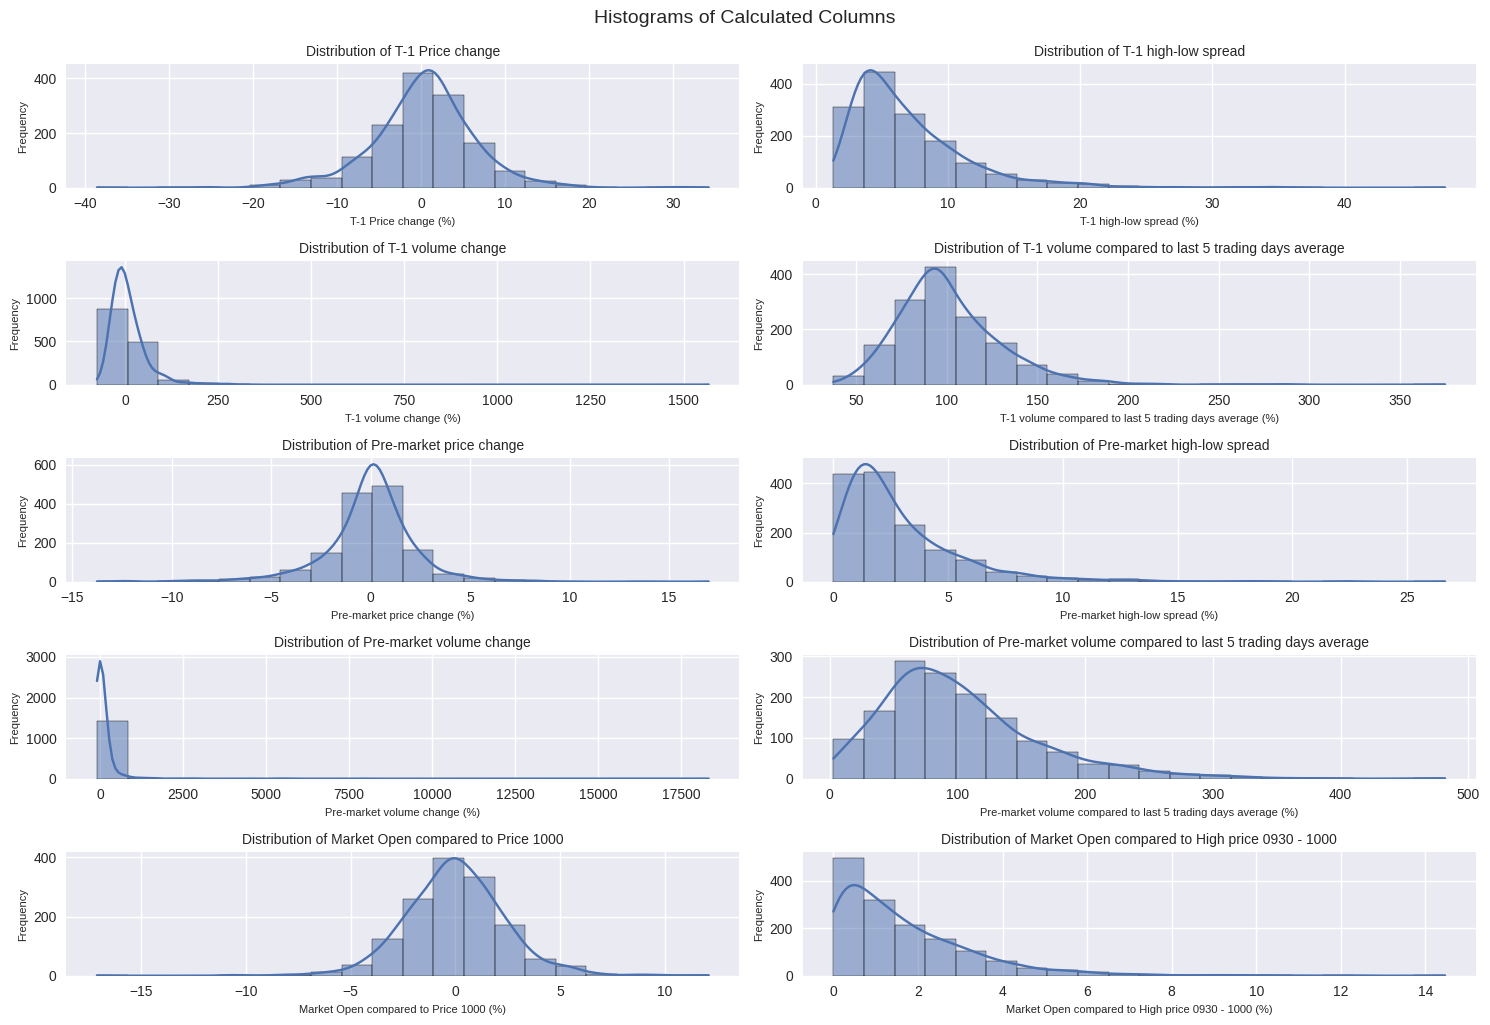

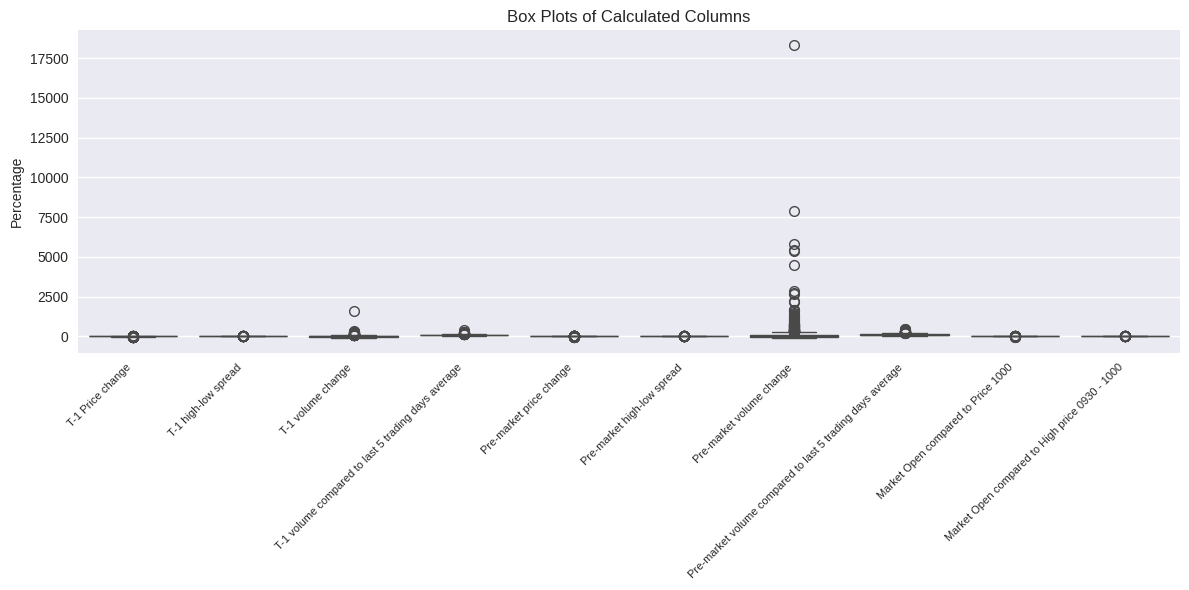

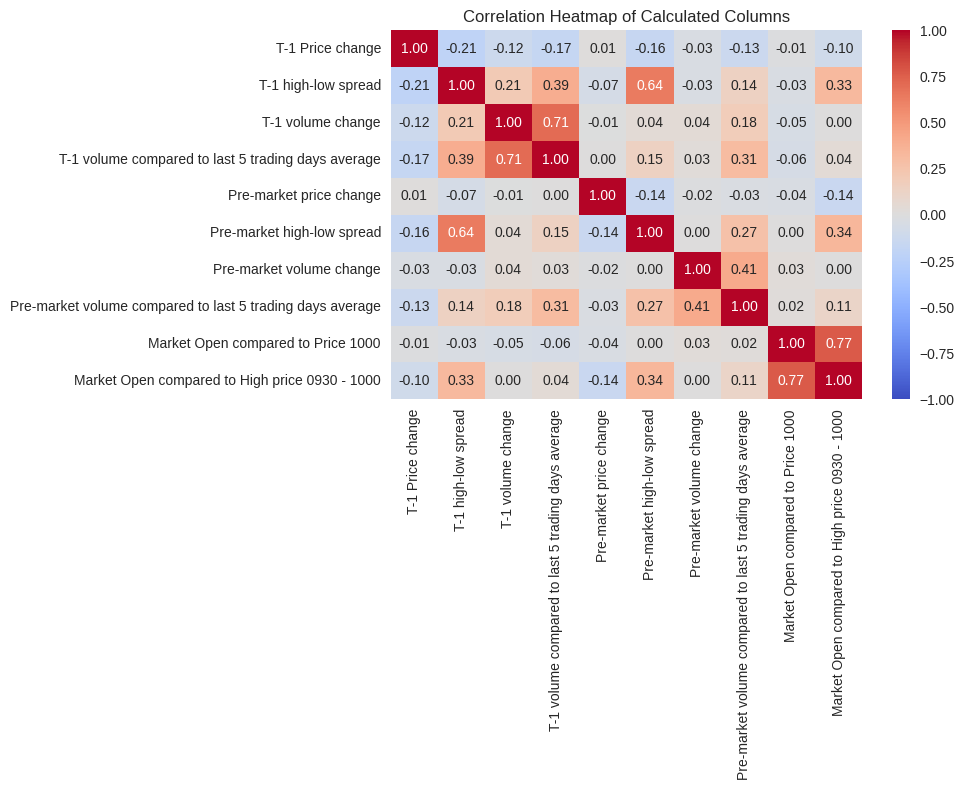

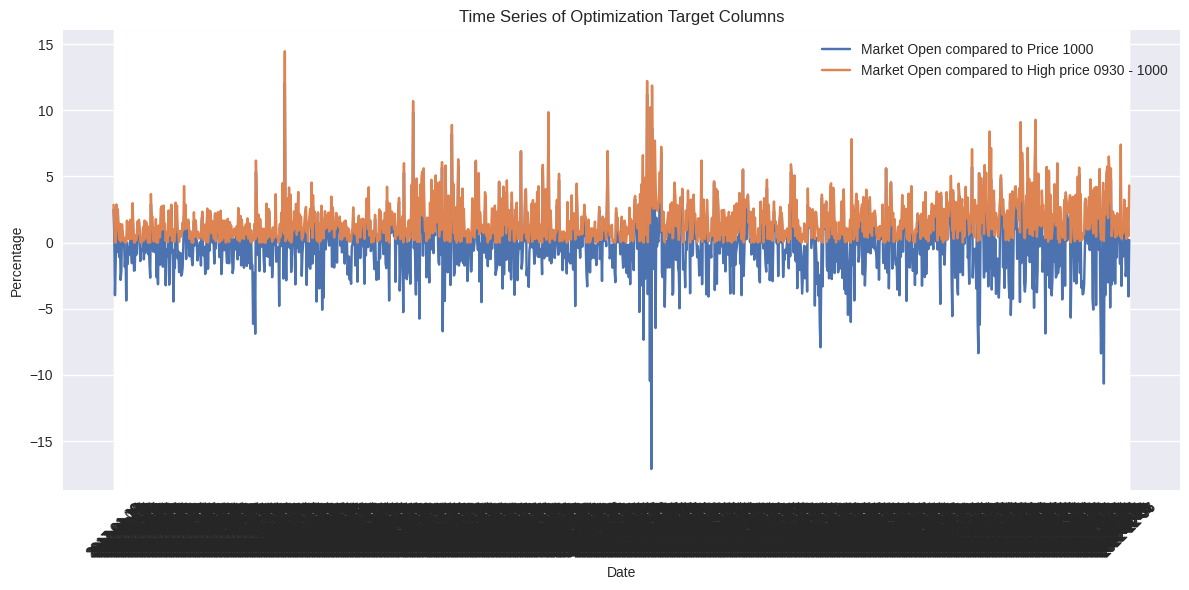

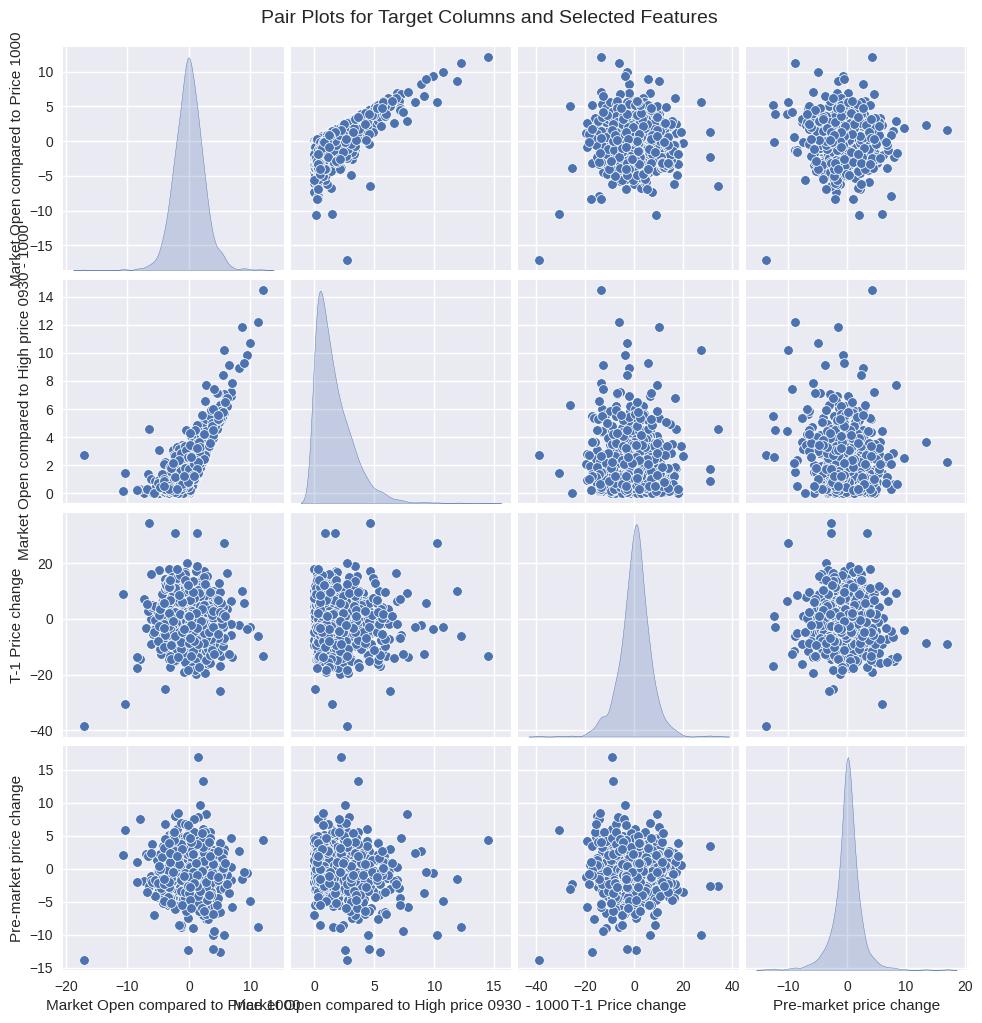

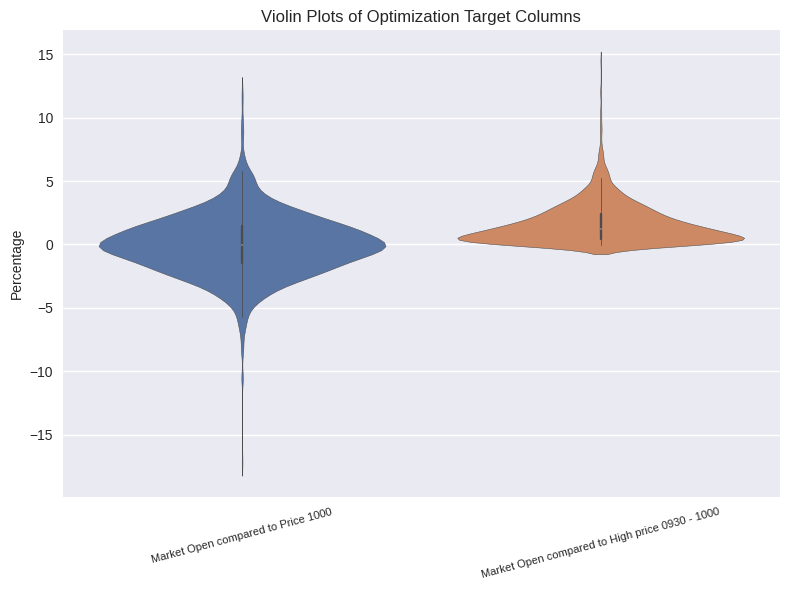


All plots displayed.


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plot style for better visualization
plt.style.use('seaborn-v0_8')  # Use a valid Matplotlib style
sns.set_palette("deep")

# Load the processed CSV data
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    return df

# Inspect and visualize the newly calculated columns
def inspect_metrics(df):
    # Define the new columns to inspect
    new_columns = [
        'T-1 Price change',
        'T-1 high-low spread',
        'T-1 volume change',
        'T-1 volume compared to last 5 trading days average',
        'Pre-market price change',
        'Pre-market high-low spread',
        'Pre-market volume change',
        'Pre-market volume compared to last 5 trading days average',
        'Market Open compared to Price 1000',
        'Market Open compared to High price 0930 - 1000'
    ]

    # Summary statistics
    print("Summary Statistics for Newly Calculated Columns:")
    print(df[new_columns].describe())

    # Check for missing values
    print("\nMissing Values in Newly Calculated Columns:")
    print(df[new_columns].isna().sum())

    # Correlation matrix
    print("\nCorrelation Matrix for Newly Calculated Columns:")
    corr_matrix = df[new_columns].corr()
    print(corr_matrix)

    # Detailed analysis for optimization target columns
    target_columns = [
        'Market Open compared to Price 1000',
        'Market Open compared to High price 0930 - 1000'
    ]

    print("\nDetailed Distribution Analysis for Optimization Targets:")
    for col in target_columns:
        print(f"\n--- {col} ---")
        # Skewness and Kurtosis
        print(f"Skewness: {stats.skew(df[col].dropna()):.4f}")
        print(f"Kurtosis: {stats.kurtosis(df[col].dropna()):.4f}")
        # Normality test (Shapiro-Wilk)
        stat, p_value = stats.shapiro(df[col].dropna())
        print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}")
        # Outlier detection using IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))][col]
        print(f"Number of Outliers (IQR method): {len(outliers)}")

    # Visualizations for all calculated columns
    # 1. Histograms for all new columns
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(new_columns, 1):
        plt.subplot(5, 2, i)
        sns.histplot(df[col].dropna(), kde=True, bins=20)
        plt.title(f'Distribution of {col}', fontsize=10)
        plt.xlabel(f'{col} (%)', fontsize=8)
        plt.ylabel('Frequency', fontsize=8)
        plt.tight_layout()
    plt.suptitle('Histograms of Calculated Columns', fontsize=14, y=1.02)
    plt.show()

    # 2. Box plots for all new columns
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[new_columns])
    plt.title('Box Plots of Calculated Columns', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.ylabel('Percentage', fontsize=10)
    plt.tight_layout()
    plt.show()

    # 3. Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Heatmap of Calculated Columns', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 4. Time series plots for target columns
    plt.figure(figsize=(12, 6))
    for col in target_columns:
        plt.plot(df['Date'], df[col], label=col)
    plt.title('Time Series of Optimization Target Columns', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Percentage', fontsize=10)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 5. Pair plots for target columns vs. others (limited to avoid clutter)
    pair_columns = target_columns + ['T-1 Price change', 'Pre-market price change']
    sns.pairplot(df[pair_columns].dropna(), diag_kind='kde')
    plt.suptitle('Pair Plots for Target Columns and Selected Features', fontsize=14, y=1.02)
    plt.show()

    # 6. Violin plots for target columns
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df[target_columns])
    plt.title('Violin Plots of Optimization Target Columns', fontsize=12)
    plt.xticks(rotation=15, fontsize=8)
    plt.ylabel('Percentage', fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\nAll plots displayed.")

# Main execution
if __name__ == "__main__":
    input_file = "train_data.csv"

    # Load and inspect data
    df = load_data(input_file)
    inspect_metrics(df)

In [ ]:
import pandas as pd

# Reading the CSV file
df = pd.read_csv('train_data.csv')

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month for grouping
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month_name()

# Extracting the relevant columns
market_open_to_1000 = df['Market Open compared to Price 1000']
market_open_to_high = df['Market Open compared to High price 0930 - 1000']

# Total number of records
total_records = len(df)

# Calculating counts and probabilities for overall data
results = {
    'Metric': [],
    'Count': [],
    'Probability (%)': []
}

# 1. Market Open compared to Price 1000 > 0
count_1 = sum(market_open_to_1000 > 0)
results['Metric'].append('Market Open > Price 1000')
results['Count'].append(count_1)
results['Probability (%)'].append((count_1 / total_records) * 100)

# 2. Market Open compared to High price 0930 - 1000 > 1
count_2 = sum(market_open_to_high > 1)
results['Metric'].append('Market Open > High price 0930-1000 by 1%')
results['Count'].append(count_2)
results['Probability (%)'].append((count_2 / total_records) * 100)

# 3. Market Open compared to High price 0930 - 1000 > 1.5
count_3 = sum(market_open_to_high > 1.5)
results['Metric'].append('Market Open > High price 0930-1000 by 1.5%')
results['Count'].append(count_3)
results['Probability (%)'].append((count_3 / total_records) * 100)

# 4. Market Open compared to High price 0930 - 1000 > 2
count_4 = sum(market_open_to_high > 2)
results['Metric'].append('Market Open > High price 0930-1000 by 2%')
results['Count'].append(count_4)
results['Probability (%)'].append((count_4 / total_records) * 100)

# 5. Market Open compared to High price 0930 - 1000 > 2.5
count_5 = sum(market_open_to_high > 2.5)
results['Metric'].append('Market Open > High price 0930-1000 by 2.5%')
results['Count'].append(count_5)
results['Probability (%)'].append((count_5 / total_records) * 100)

# 6. Market Open compared to High price 0930 - 1000 > 3
count_6 = sum(market_open_to_high > 3)
results['Metric'].append('Market Open > High price 0930-1000 by 3%')
results['Count'].append(count_6)
results['Probability (%)'].append((count_6 / total_records) * 100)

# 7. 1 OR 2
count_7 = sum((market_open_to_1000 > 0) | (market_open_to_high > 1))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 1%')
results['Count'].append(count_7)
results['Probability (%)'].append((count_7 / total_records) * 100)

# 8. 1 OR 3
count_8 = sum((market_open_to_1000 > 0) | (market_open_to_high > 1.5))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 1.5%')
results['Count'].append(count_8)
results['Probability (%)'].append((count_8 / total_records) * 100)

# 9. 1 OR 4
count_9 = sum((market_open_to_1000 > 0) | (market_open_to_high > 2))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 2%')
results['Count'].append(count_9)
results['Probability (%)'].append((count_9 / total_records) * 100)

# 10. 1 OR 5
count_10 = sum((market_open_to_1000 > 0) | (market_open_to_high > 2.5))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 2.5%')
results['Count'].append(count_10)
results['Probability (%)'].append((count_10 / total_records) * 100)

# 11. 1 OR 6
count_11 = sum((market_open_to_1000 > 0) | (market_open_to_high > 3))
results['Metric'].append('Market Open > Price 1000 OR > High price 0930-1000 by 3%')
results['Count'].append(count_11)
results['Probability (%)'].append((count_11 / total_records) * 100)

# Creating a DataFrame for overall results
results_df = pd.DataFrame(results)

# Printing the overall results
print(f"Total records: {total_records}")
print("\nOverall Counts and Probabilities:")
print(results_df.to_string(index=False))

# Saving overall results to a CSV file
results_df.to_csv('analysis_results_overall.csv', index=False)

# Breakdown by Year
years = range(2017, 2026)
year_results = {'Metric': results['Metric']}
for year in years:
    year_df = df[df['Year'] == year]
    if len(year_df) == 0:
        continue
    year_total = len(year_df)
    year_counts = []

    # Calculate counts for each metric
    year_counts.append(sum(year_df['Market Open compared to Price 1000'] > 0))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 1))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 1.5))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 2))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 2.5))
    year_counts.append(sum(year_df['Market Open compared to High price 0930 - 1000'] > 3))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 1)))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 1.5)))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 2)))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 2.5)))
    year_counts.append(sum((year_df['Market Open compared to Price 1000'] > 0) | (year_df['Market Open compared to High price 0930 - 1000'] > 3)))

    # Convert counts to probabilities
    year_probs = [(count / year_total) * 100 for count in year_counts]
    year_results[str(year)] = year_probs

# Creating a DataFrame for yearly results
year_results_df = pd.DataFrame(year_results)

# Printing the yearly breakdown
print("\nCounts and Probabilities by Year (%):")
print(year_results_df.to_string(index=False))

# Saving yearly results to a CSV file
year_results_df.to_csv('analysis_results_by_year.csv', index=False)

# Breakdown by Month
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
month_results = {'Metric': results['Metric']}
for month in months:
    month_df = df[df['Month'] == month]
    if len(month_df) == 0:
        continue
    month_total = len(month_df)
    month_counts = []

    # Calculate counts for each metric
    month_counts.append(sum(month_df['Market Open compared to Price 1000'] > 0))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 1))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 1.5))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 2))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 2.5))
    month_counts.append(sum(month_df['Market Open compared to High price 0930 - 1000'] > 3))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 1)))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 1.5)))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 2)))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 2.5)))
    month_counts.append(sum((month_df['Market Open compared to Price 1000'] > 0) | (month_df['Market Open compared to High price 0930 - 1000'] > 3)))

    # Convert counts to probabilities
    month_probs = [(count / month_total) * 100 for count in month_counts]
    month_results[month] = month_probs

# Creating a DataFrame for monthly results
month_results_df = pd.DataFrame(month_results)

# Printing the monthly breakdown
print("\nCounts and Probabilities by Month (%):")
print(month_results_df.to_string(index=False))

# Saving monthly results to a CSV file
month_results_df.to_csv('analysis_results_by_month.csv', index=False)

Total records: 1442

Overall Counts and Probabilities:
                                                    Metric  Count  Probability (%)
                                  Market Open > Price 1000    711        49.306519
                  Market Open > High price 0930-1000 by 1%    815        56.518724
                Market Open > High price 0930-1000 by 1.5%    608        42.163662
                  Market Open > High price 0930-1000 by 2%    457        31.692094
                Market Open > High price 0930-1000 by 2.5%    339        23.509015
                  Market Open > High price 0930-1000 by 3%    237        16.435506
  Market Open > Price 1000 OR > High price 0930-1000 by 1%    899        62.343967
Market Open > Price 1000 OR > High price 0930-1000 by 1.5%    799        55.409154
  Market Open > Price 1000 OR > High price 0930-1000 by 2%    755        52.357836
Market Open > Price 1000 OR > High price 0930-1000 by 2.5%    737        51.109570
  Market Open > Price 1000 OR > 

## 2. Model Training

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# Load the training data
df_train = pd.read_csv("train_data.csv")

# Calculate the defined result for each sample
defined_result = np.where(
    df_train["Market Open compared to High price 0930 - 1000"] >= 1,
    1,
    df_train["Market Open compared to Price 1000"]
)

# Create the target variable: y = 0 (Buy) if defined_result > 0, else y = 1 (Not Buy)
y_train = (defined_result <= 0).astype(int)

# Define input features
feature_cols = [
    "T-1 Price change",
    "T-1 high-low spread",
    "T-1 volume change",
    "T-1 volume compared to last 5 trading days average",
    "Pre-market price change",
    "Pre-market high-low spread",
    "Pre-market volume change",
    "Pre-market volume compared to last 5 trading days average"
]
X_train = df_train[feature_cols].values

# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Build the revised model
model = tf.keras.Sequential([
    layers.Dense(8, activation="relu", input_shape=(8,),
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(8, activation="relu",
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model with a higher learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["accuracy"])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with class weights
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2,
          class_weight=class_weight_dict, callbacks=[early_stopping], verbose=1)

# Export the trained model in HDF5 format
model.save("trading_signal_model.h5")

# Function to calculate defined result based on model predictions
def calculate_defined_result(predictions, df):
    defined_results = []
    for i, pred in enumerate(predictions):
        if pred < 0.5:  # Predict Buy (0)
            if df["Market Open compared to High price 0930 - 1000"].iloc[i] >= 1:
                defined_results.append(1)
            else:
                defined_results.append(df["Market Open compared to Price 1000"].iloc[i])
        else:  # Predict Not Buy (1)
            defined_results.append(0)
    return np.array(defined_results)

# Make predictions on the training set
y_pred_proba = model.predict(X_train)  # Use scaled features
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate defined results
defined_results = calculate_defined_result(y_pred, df_train)

# Evaluate performance
false_negatives = ((y_pred == 1) & (defined_result > 0)).sum()  # Missed positives
false_positives = ((y_pred == 0) & (defined_results <= 0)).sum()  # Incorrect Buy leading to loss/no gain
buy_predictions = (y_pred == 0).sum()

print(f"Number of missed positive results (False Negatives): {false_negatives}")
print(f"Number of Buy predictions leading to loss/no gain (False Positives): {false_positives}")
print(f"Total Buy predictions: {buy_predictions}")
print(f"Proportion of missed positives: {false_negatives / (defined_result > 0).sum():.4f}")
print(f"Proportion of Buy predictions leading to loss: {false_positives / buy_predictions:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5063 - loss: 1.3472 - val_accuracy: 0.3287 - val_loss: 1.3459
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5022 - loss: 1.2907 - val_accuracy: 0.4291 - val_loss: 0.9867
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5267 - loss: 1.2167 - val_accuracy: 0.5433 - val_loss: 0.8842
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5350 - loss: 1.1793 - val_accuracy: 0.5813 - val_loss: 0.8436
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4900 - loss: 1.2761 - val_accuracy: 0.5952 - val_loss: 0.8304
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5093 - loss: 1.1370 - val_accuracy: 0.5882 - val_loss: 0.8293
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5168 - loss: 1.2103 - val_accuracy: 0.6055 - val_loss: 0.8220
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5424 - loss: 1.1639 - val_accuracy: 0.6021 - val_loss: 0.8226
Ep

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Number of missed positive results (False Negatives): 179
Number of Buy predictions leading to loss/no gain (False Positives): 436
Total Buy predictions: 1156
Proportion of missed positives: 0.1991
Proportion of Buy predictions leading to loss: 0.3772


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
import tensorflow.keras.backend as K

# Load the training data
df_train = pd.read_csv("train_data.csv")

# Calculate the defined result for each sample
defined_result = np.where(
    df_train["Market Open compared to High price 0930 - 1000"] >= 1,
    1,
    df_train["Market Open compared to Price 1000"]
)

# Create the target variable: y = 0 (Buy) if defined_result > 0, else y = 1 (Not Buy)
y_train = (defined_result <= 0).astype(int)

# Define input features
feature_cols = [
    "T-1 Price change",
    "T-1 high-low spread",
    "T-1 volume change",
    "T-1 volume compared to last 5 trading days average",
    "Pre-market price change",
    "Pre-market high-low spread",
    "Pre-market volume change",
    "Pre-market volume compared to last 5 trading days average"
]
X_train = df_train[feature_cols].values

# Adjusted class weights for balance
class_weight_dict = {
    0: 1.0,  # Buy signals
    1: 2.0   # Not Buy signals (balanced to reduce false positives)
}

# Custom F1 score metric
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)

    tp = K.sum(K.cast(y_true * y_pred, 'float32'))
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

# Enhanced model architecture
model = tf.keras.Sequential([
    layers.Dense(24, input_shape=(8,), kernel_regularizer=regularizers.l2(0.005)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(16, kernel_regularizer=regularizers.l2(0.005)),
    layers.LeakyReLU(alpha=0.01),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(8, kernel_regularizer=regularizers.l2(0.005)),
    layers.LeakyReLU(alpha=0.01),
    layers.Dropout(0.2),

    layers.Dense(1, activation="sigmoid")
])

# Compile with binary cross-entropy
optimizer = Adam(learning_rate=0.002)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", f1_metric]
)

# Callbacks with F1 monitoring
early_stopping = EarlyStopping(
    monitor='val_f1_metric',
    patience=30,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_metric',
    factor=0.5,
    patience=20,
    mode='max',
    min_lr=0.0001
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Export the trained model
model.save("trading_signal_model_v6.h5")

# Function to calculate defined result
def calculate_defined_result(predictions, df):
    defined_results = []
    for i, pred in enumerate(predictions):
        if pred < 0.5:  # Predict Buy (0)
            if df["Market Open compared to High price 0930 - 1000"].iloc[i] >= 1:
                defined_results.append(1)
            else:
                defined_results.append(df["Market Open compared to Price 1000"].iloc[i])
        else:  # Predict Not Buy (1)
            defined_results.append(0)
    return np.array(defined_results)

# Make predictions and optimize threshold
y_pred_proba = model.predict(X_train)

# Find optimal threshold for F1 score
thresholds = np.arange(0.1, 0.9, 0.05)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred_temp = (y_pred_proba > threshold).astype(int).flatten()
    defined_results_temp = calculate_defined_result(y_pred_temp, df_train)

    tp = ((y_pred_temp == 0) & (defined_result > 0)).sum()
    fp = ((y_pred_temp == 0) & (defined_results_temp <= 0)).sum()
    fn = ((y_pred_temp == 1) & (defined_result > 0)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}")

# Final predictions with optimal threshold
y_pred = (y_pred_proba > best_threshold).astype(int).flatten()
defined_results = calculate_defined_result(y_pred, df_train)

# Evaluate performance
false_negatives = ((y_pred == 1) & (defined_result > 0)).sum()
false_positives = ((y_pred == 0) & (defined_results <= 0)).sum()
buy_predictions = (y_pred == 0).sum()
total_positives = (defined_result > 0).sum()

print(f"\n=== Model Performance with Optimized Threshold ===")
print(f"Number of missed positive results (False Negatives): {false_negatives}")
print(f"Number of Buy predictions leading to lossjudge_positives: {false_positives}")
print(f"Total Buy predictions: {buy_predictions}")
print(f"Total positive opportunities: {total_positives}")
print(f"Proportion of missed positives: {false_negatives / total_positives:.4f}")
if buy_predictions > 0:
    print(f"Proportion of Buy predictions leading to loss: {false_positives / buy_predictions:.4f}")
    print(f"Precision (successful buys): {(buy_predictions - false_positives) / buy_predictions:.4f}")
print(f"Recall (caught opportunities): {(total_positives - false_negatives) / total_positives:.4f}")

# Trading summary
successful_buys = buy_predictions - false_positives
captured_profit = total_positives - false_negatives

print(f"\n=== Trading Performance Summary ===")
print(f"Successful buy signals: {successful_buys}")
print(f"Captured profit opportunities: {captured_profit} out of {total_positives}")
print(f"Profit capture rate: {captured_profit / total_positives:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4742 - f1_metric: 0.5291 - loss: 1.2780 - val_accuracy: 0.6782 - val_f1_metric: 0.1222 - val_loss: 0.8571 - learning_rate: 0.0020
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4916 - f1_metric: 0.5096 - loss: 1.2183 - val_accuracy: 0.5779 - val_f1_metric: 0.2581 - val_loss: 0.8552 - learning_rate: 0.0020
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5031 - f1_metric: 0.5195 - loss: 1.1835 - val_accuracy: 0.5190 - val_f1_metric: 0.3165 - val_loss: 0.8586 - learning_rate: 0.0020
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4862 - f1_metric: 0.4831 - loss: 1.1193 - val_accuracy: 0.4429 - val_f1_metric: 0.3616 - val_loss: 0.8595 - learning_rate: 0.0020
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4754 - f1_metric: 0.4910 - loss: 1.1369 - val_accuracy: 0.4325 - val_f1_metric: 0.3681 - val_loss: 0.8547 - learning_rate: 0.0020
Epoch 6/20
37/37 ━━━━━━━━━

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Optimal threshold: 0.650

=== Model Performance with Optimized Threshold ===
Number of missed positive results (False Negatives): 1
Number of Buy predictions leading to lossjudge_positives: 542
Total Buy predictions: 1440
Total positive opportunities: 899
Proportion of missed positives: 0.0011
Proportion of Buy predictions leading to loss: 0.3764
Precision (successful buys): 0.6236
Recall (caught opportunities): 0.9989

=== Trading Performance Summary ===
Successful buy signals: 898
Captured profit opportunities: 898 out of 899
Profit capture rate: 0.9989
